# Classifier model for personal spendings

TODO:

- [X] Create model file
- [X] Cross-validate several models
- [] Pick the best 2 models and tune the hyperparameters
- [X] Test with tfidf

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


## Set Env variables

In [2]:
from pathlib import Path
root_dir = Path('.')

In [47]:
test_size = 0.3
seed = 1

## Load dataset

In [4]:
from data_loader import load_treated_dataset

complete_dataset = load_treated_dataset(root_dir)

## Split test and train

In [5]:
from training import split_train_test
train, test = split_train_test(complete_dataset, test_size=test_size)
X_train = train[[i for i in train.columns if i != 'categoria']]

In [53]:
X_test = test[[i for i in test.columns if i != 'categoria']]

### Encode y classifications

In [ ]:
from sklearn.preprocessing import LabelEncoder
y_train = train['categoria']
y_enconder = LabelEncoder().fit(y_train)
y_train_encoded = y_enconder.transform(y_train)

In [54]:
y_test = test['categoria']
y_test_encoded = y_enconder.transform(y_test)

## Model Cross-validation

In [7]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'balanced_accuracy', 'recall_weighted', 'precision_weighted',  'f1_weighted']

### Test models

In [10]:
from preprocess import get_preprocessing_transformer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.preprocessing import Normalizer

model_candidates = {
    "Logistic Regression": LogisticRegression( verbose=0),
    "Ridge Classifier": RidgeClassifier(),
    "Multinomial Naive Bayes": Pipeline(steps=[ Normalizer(),
                                                CategoricalNB( )], verbose=False), # CategoricalNB does not support normalization, so we use Normalizer before it  
    "Gaussian Naive Bayes": Pipeline(steps=[ Normalizer(),
                                                GaussianNB( )],  verbose=False), # CategoricalNB does not support normalization, so we use Normalizer before it  
    # "Support Vector Machine Classifier": LinearSVC(verbose=0), AttributeError: 'numpy.ndarray' object has no attribute 'lower'
    "KNN": KNeighborsClassifier(),
    "Gradient boosting": GradientBoostingClassifier(
                            n_estimators=100,    # Number of boosting stages
                            learning_rate=0.1,   # Step size shrinkage
                            max_depth=3,         # Maximum depth of each tree
                            random_state=42,
                            verbose=False
                        ),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42, verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators=100, random_state=42) 
}

model_pipelines ={model_name: Pipeline(
                                steps=[("preprocessor", get_preprocessing_transformer()), (model_name, model)],
                                verbose=False
                            ) for model_name, model in model_candidates.items()} 


In [ ]:
import pandas as pd


cross_validation_avg_test_results = []

for model_name, clf in model_pipelines.items():
    print(f"Evaluating model: {model_name}")
    try:
        model_result = cross_validate(clf, X_train, y_train_encoded, scoring=scoring, verbose=0 )
        model_avg = {i:v.mean() for i, v in  model_result.items() if 'test' in i}
        cross_validation_avg_test_results.append( {**model_avg, 'model': model_name})
    except Exception as e:
        print(f"Error in model: {model_name}: {e}")

model_crossvalidation_results = pd.DataFrame(cross_validation_avg_test_results)

In [20]:
model_crossvalidation_results['avg_score'] = model_crossvalidation_results[[i for i in model_crossvalidation_results.columns if 'test' in i]].mean(axis=1)
model_crossvalidation_results = model_crossvalidation_results.sort_values(by='avg_score', ascending=False)
model_crossvalidation_results.set_index('model', inplace=True)
model_crossvalidation_results

test_accuracy  test_balanced_accuracy  \
model                                                             
Ridge Classifier               0.708333                0.530083   
Logistic Regression            0.690000                0.493962   
Random Forest Classifier       0.673333                0.489730   
Gradient boosting              0.646667                0.499429   
KNN                            0.595000                0.384176   
AdaBoost Classifier            0.446667                0.232371   

                          test_recall_weighted  test_precision_weighted  \
model                                                                     
Ridge Classifier                      0.708333                 0.695096   
Logistic Regression                   0.690000                 0.668213   
Random Forest Classifier              0.673333                 0.663021   
Gradient boosting                     0.646667                 0.644810   
KNN                                   0.595000                 0.578802   
AdaBoost Classifier                   0.446667                 0.370596   

                          test_f1_weighted  avg_score  
model                                                  
Ridge Classifier                  0.687624   0.665894  
Logistic Regression               0.664068   0.641249  
Random Forest Classifier          0.641645   0.628212  
Gradient boosting                 0.631169   0.613748  
KNN                               0.560988   0.542793  
AdaBoost Classifier               0.371527   0.373565

Text(0.5, 1.0, 'Model Cross-Validation Results')

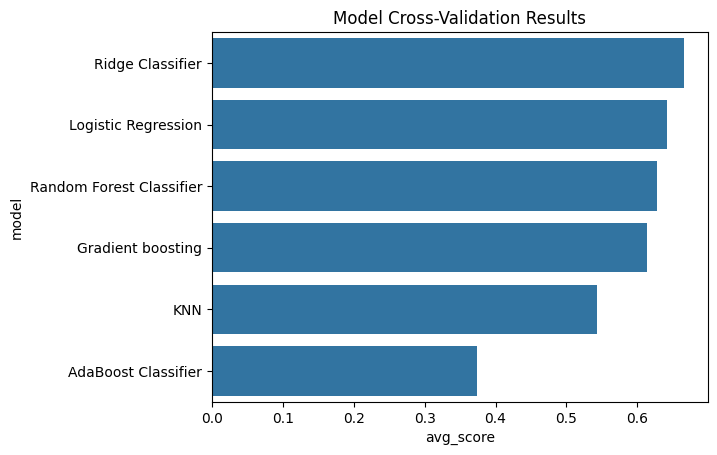

In [21]:
sns.barplot(data=model_crossvalidation_results, x='avg_score', y=model_crossvalidation_results.index, orient='h')
plt.title('Model Cross-Validation Results')

## Select the best models for hyperparameter tunning

In [25]:
best_models = model_crossvalidation_results.index[:3].to_list()
print(f"Best models were: {best_models}")

Best models were: ['Ridge Classifier', 'Logistic Regression', 'Random Forest Classifier']


## Select Hyper parameters

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [18]:
import numpy as np

param_grid = {
                "Ridge Classifier" :{'alpha': np.linspace(0.1, 1, num = 3), 
                                    'class_weight': ['balanced', None]},
                "Logistic Regression" :{
                                        'solver' : ['lbfgs', 'liblinear', 'sag'],
                                        'C': [10, 1.0, 0.1]},
                "Random Forest Classifier" :{
                                            # 'criterion': ['gini', 'entropy'],
                                            # 'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                                            # 'min_samples_leaf': [1, 2, 4],
                                            'min_samples_split': [2, 5, 10],
                                            'max_features': [None, 'sqrt', 0.3],
                                            # 'n_estimators':[int(x) for x in np.linspace(start = 40, stop = 150, num = 20)]
                                            },
            }

In [ ]:
hyper_param_tunning_results = {}
#preprocess data for the hyper parameter tuning
X_train_processed =  get_preprocessing_transformer().fit(X_train).transform(X_train)
for model_name, params in param_grid.items():
    print(f"Running grid search for model: {model_name}")
    model =  model_candidates[model_name]
    grid = param_grid[model_name]
    
    # Perform grid search
    grid_search = GridSearchCV(estimator=model, cv=2, param_grid=grid, scoring='f1_weighted', verbose=0, n_jobs=-1)
    grid_result = grid_search.fit(X_train_processed, y_train)
    hyper_param_tunning_results[model_name] = grid_result

## Hyperparameter tunning analysis

In [ ]:
hyperparameter_tunning_scores = {estimator:grid_search.best_score_ for estimator,grid_search in hyper_param_tunning_results.items()}

best_estimator = sorted(hyperparameter_tunning_scores.items(), key=lambda item: item[1], reverse=True)[0]

In [38]:
print(f'best estimator is {best_estimator[0]} with score {best_estimator[1]} and parameters {hyper_param_tunning_results[best_estimator[0]].best_params_}')

best estimator is Ridge Classifier with score 0.6566580372496947 and parameters {'alpha': np.float64(0.55), 'class_weight': None}


<Axes: >

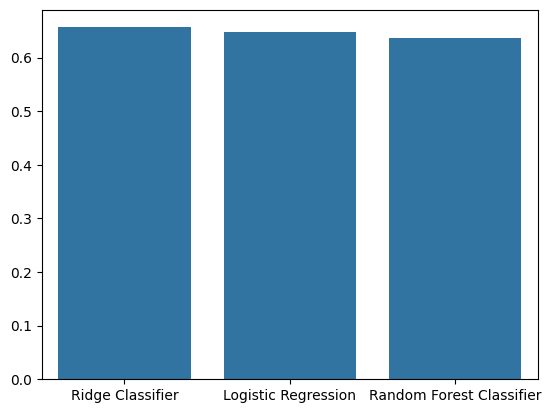

In [29]:
sns.barplot({estimator:grid_search.best_score_ for estimator,grid_search in hyper_param_tunning_results.items()})

### Re-run cross-validation with best parameters

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

hyper_parameter_scores = []
model_names = []
# Parâmetros e partições da validação cruzada
scoring = 'f1_weighted'
splits = 3
kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed) # validação cruzada com estratificação

for model_name, clf in hyper_param_tunning_results.items():
    print(f"Evaluating model: {model_name}")
    model = clf.best_estimator_
    try:
        model_result = cross_val_score(clf, X_train_processed, y_train_encoded, scoring=scoring, verbose=0 )
        hyper_parameter_scores.append(model_result)
        model_names.append(model_name)
    except Exception as e:
        print(f"Error in model: {model_name}: {e}")

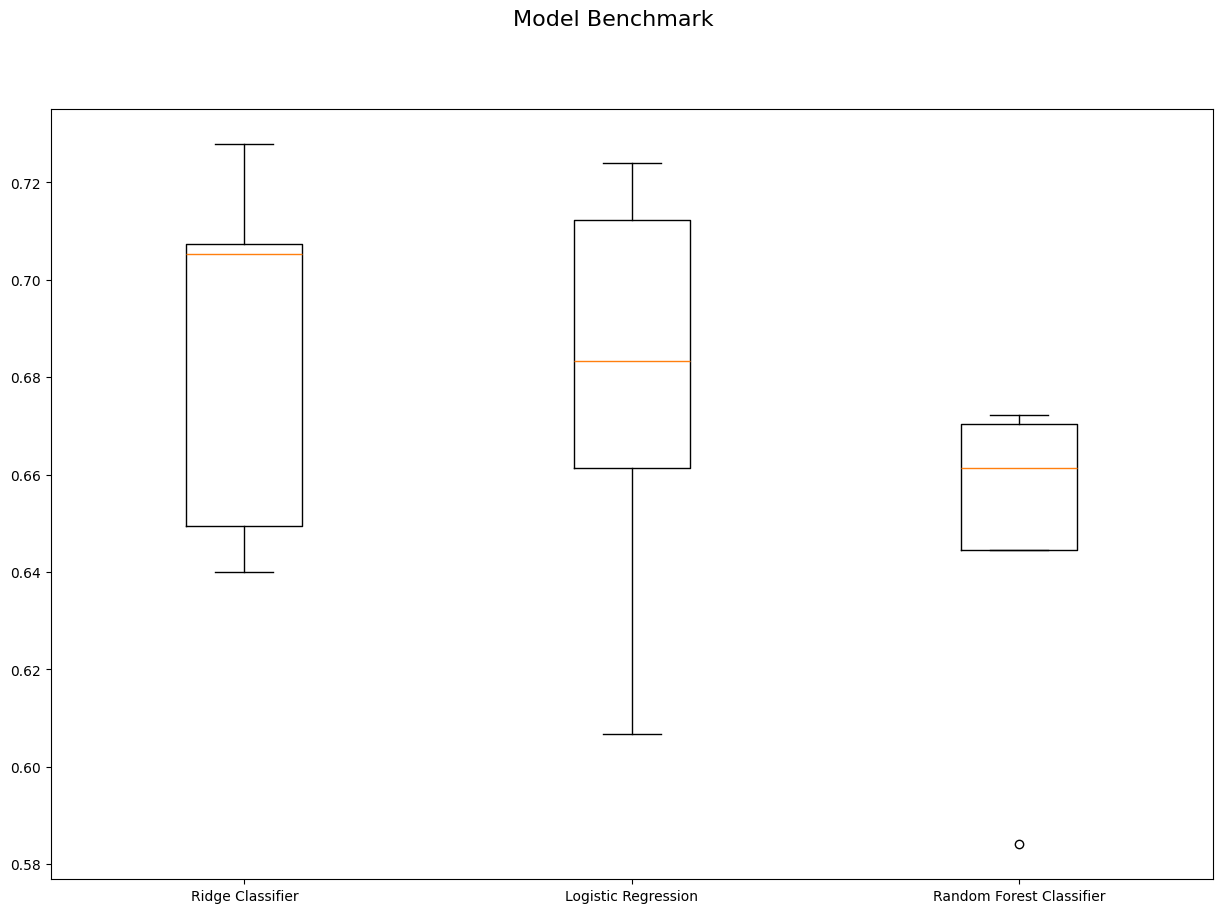

In [52]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Model Benchmark', fontsize=16)
ax = fig.add_subplot(111)
plt.boxplot(hyper_parameter_scores)
ax.set_xticklabels(model_names)
plt.show()

# Test Models with hyperparameter tunning

In [59]:
X_test_processed =  get_preprocessing_transformer().fit(X_train).transform(X_test)

          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 600/600 [00:08<00:00, 68.39 examples/s]


          Data
134 2022-12-11
206 2023-04-01
714 2023-11-07
720 2023-11-10
69  2023-01-19


Map: 100%|██████████| 258/258 [00:05<00:00, 45.60 examples/s]


In [81]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

model_names = []

metrics = [('balanced_accuracy_score', balanced_accuracy_score), ('confusion_matrix', confusion_matrix)]
test_scores = { metric_name: [] for metric_name, _ in metrics }

for model_name, clf in hyper_param_tunning_results.items():
    print(f"Evaluating model: {model_name}")
    model = clf.best_estimator_
    model_names.append(model_name)
    try:
        predictions = model.predict(X_test_processed)
        predictions_encoded = y_enconder.transform(predictions)

        for metric_name, metric in metrics:
            if metric == roc_auc_score:
                model_result = metric(y_test_encoded, predictions_encoded, average='weighted')
            else:
                model_result = metric(y_test_encoded, predictions_encoded)
            test_scores[metric_name].append(model_result) 
    except Exception as e:
        print(f"Error in model: {model_name}: {e}")

Evaluating model: Ridge Classifier
Evaluating model: Logistic Regression
Evaluating model: Random Forest Classifier


C:\Users\guilh\AppData\Local\Temp\ipykernel_29092\1286417807.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names)


[Text(0, 0, 'Ridge Classifier'),
 Text(1, 0, 'Logistic Regression'),
 Text(2, 0, 'Random Forest Classifier')]

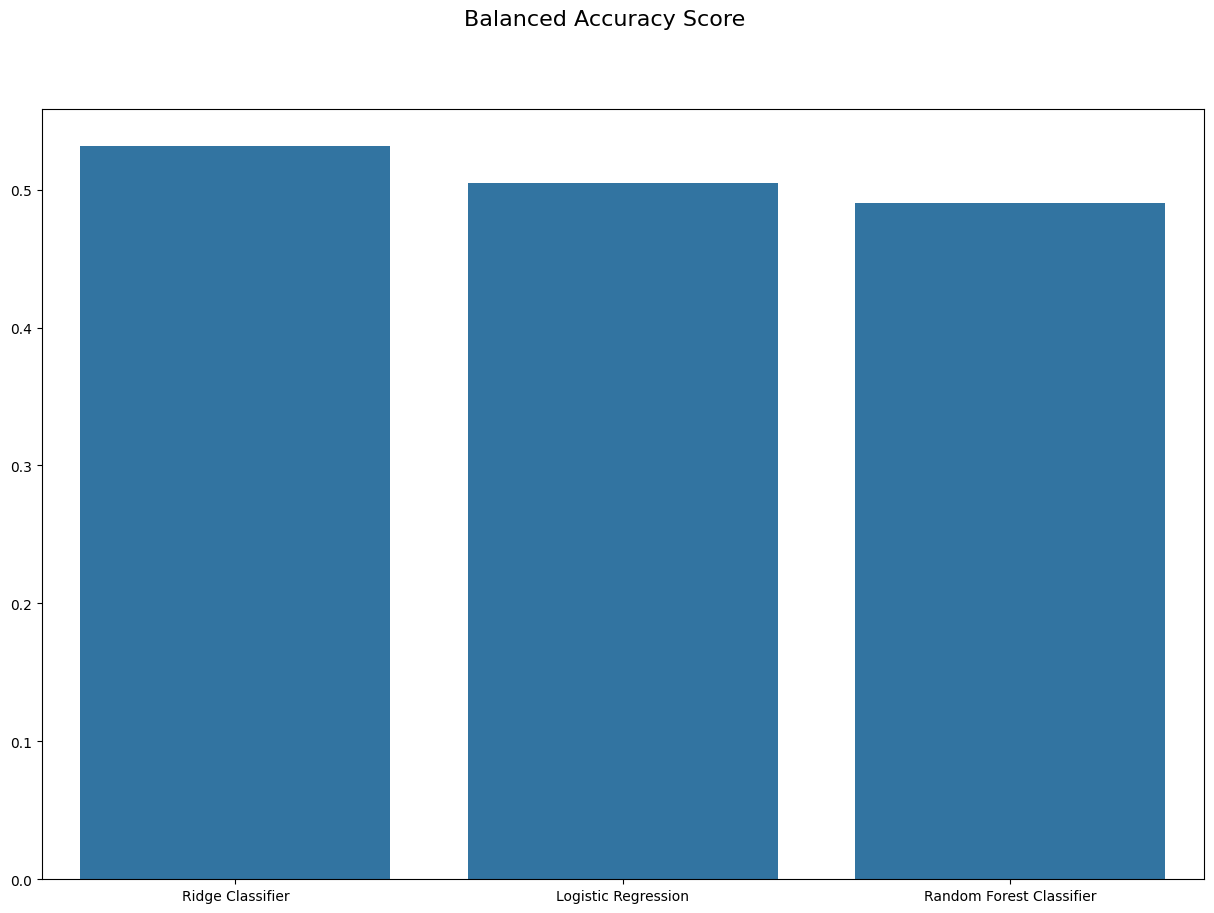

In [97]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Balanced Accuracy Score', fontsize=16)
ax = fig.add_subplot(111)
sns.barplot(test_scores['balanced_accuracy_score'])
ax.set_xticklabels(model_names)

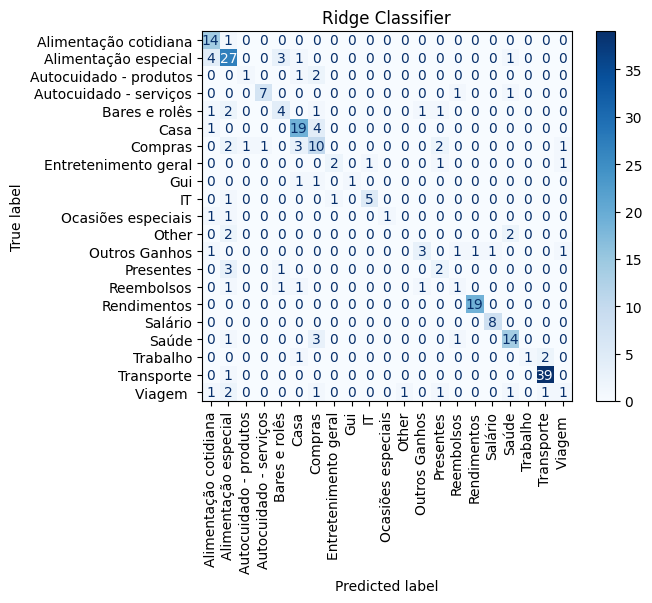

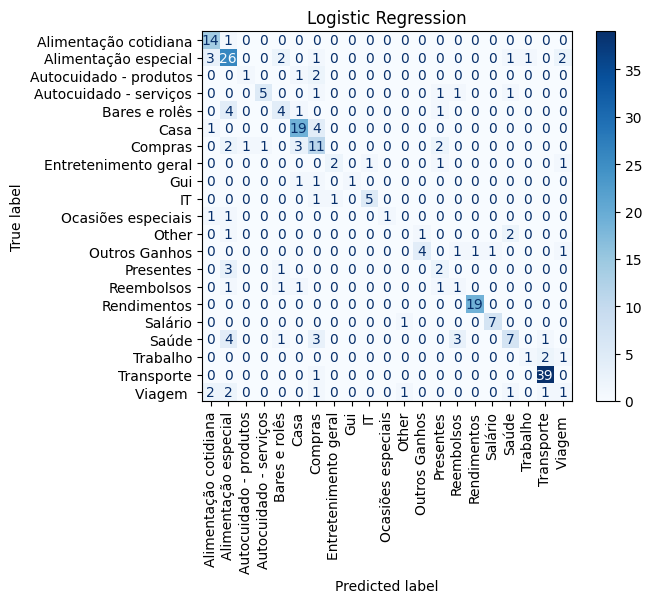

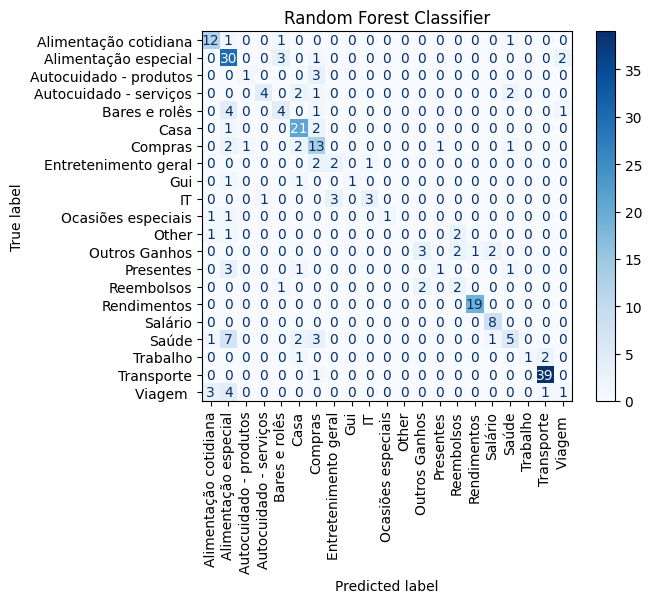

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

nrows=len(model_names)
ncols=1 
for i, model_name in enumerate(model_names):
    data = test_scores['confusion_matrix'][i]
    model = hyper_param_tunning_results[model_name].best_estimator_
    try:
        ax = fig.add_subplot(nrows,ncols,i+1)
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test_processed,
            y_test,
            display_labels=y_enconder.classes_,
            cmap=plt.cm.Blues,
        )
        
        disp.ax_.set_title(model_name)
        disp.ax_.tick_params(axis='x', labelrotation=90)
    except:
        print('Rrror ploting confusion matrix for model: ', model_name)

## Save model

In [136]:
import pickle

def save_data_pkl(file_path, obj):
    with open(file_path, "wb") as f:
        print(f'Saving the "{file_path}"')
        pickle.dump(obj, f)

In [ ]:
print(f'Saving the "{best_estimator[0]}" model to classification_model.pkl')
save_data_pkl("classification_model.pkl", hyper_param_tunning_results[best_estimator[0]].best_estimator_)

Saving the "Ridge Classifier" model to classification_model.pkl


## Save data for testing the model

In [ ]:
X_test

In [ ]:
save_data_pkl("X_test_preprocessed.pkl", X_test_processed)   

Saving the "X_test_preprocessed" data to pkl
Saving the "X_test_preprocessed.pkl"


In [138]:
save_data_pkl("y_predictions_encoded.pkl", y_enconder.transform(predictions))   

Saving the "y_predictions_encoded.pkl"


In [139]:
save_data_pkl("y_test_encoded.pkl", y_test_encoded)   

Saving the "y_test_encoded.pkl"


In [ ]:
save_data_pkl("model_result.pkl", model_result)   

In [142]:
metric_name, metric = metrics[0]
save_data_pkl(f"{metric_name}.pkl", metric)   

Saving the "balanced_accuracy_score.pkl"
